In [36]:
# Lab 05– Classification Models &amp; Ensemble Evaluation
# Learning Outcomes
# By the end of this lab, students will be able to:
# Train logistic regression, decision tree (using library and from scratch)
# Evaluate models using accuracy, ROC AUC, and confusion matrix.
# Interpret trade-offs between models.
# P — Project

# Preprocess Churn dataset (encoding, scaling).
# Train/test split.
# Fit:
# Logistic Regression
# Decision Tree
# Evaluate all models with metrics table &amp; ROC curves.
# Save best model.
# Resources
# Sklearn Model Evaluation – https://scikitlearn. org/stable/modules/model_evaluation.html
# Confusion Matrix in Sklearn – https://scikitlearn.
# org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [37]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay,
    classification_report
)
from sklearn.utils.validation import check_is_fitted

import joblib
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True)


In [38]:
dataset_path = "LabAssig5_stuff/churn.csv"

df = pd.read_csv(dataset_path)
df = df.dropna(subset=["Churn"])

# Normalize to binary int
df["Churn"] = df["Churn"].astype(str).str.strip()
y = df["Churn"].map({
    True: 1, False: 0,
    "True": 1, "False": 0,
    "Yes": 1, "No": 0,
    "Y": 1, "N": 0,
    "1": 1, "0": 0
}).astype(int)

X = df.drop(columns=["Churn"])
print("Shape:", df.shape)
display(df.head(3))


Shape: (667, 20)


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True


In [39]:
# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Handle all-NaN or empty
if len(num_cols) == 0 and len(cat_cols) == 0:
    raise ValueError("No usable feature columns found.")

num_transformer = StandardScaler()

try:
    cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols) if len(num_cols) else ("num", "drop", []),
        ("cat", cat_transformer, cat_cols) if len(cat_cols) else ("cat", "drop", []),
    ]
)

print(f"# numeric: {len(num_cols)}, # categorical: {len(cat_cols)}")


# numeric: 16, # categorical: 3


In [40]:
# Stratification condition
strata = y if y.nunique() > 1 else None

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=strata
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Target balance (train):", y_train.mean().round(4))
print("Target balance (test):", y_test.mean().round(4))


Train shape: (533, 19)  Test shape: (134, 19)
Target balance (train): 0.1426
Target balance (test): 0.1418


In [41]:
log_reg = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, solver="lbfgs", n_jobs=None))
])

dtree = Pipeline([
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(random_state=42))
])

# Fit models
log_reg.fit(X_train, y_train)
dtree.fit(X_train, y_train)

check_is_fitted(log_reg)
check_is_fitted(dtree)


In [42]:
def evaluate_model(name, pipe, X_tr, y_tr, X_te, y_te, threshold=0.5):
    # Get probabilities for positive class
    if hasattr(pipe, "predict_proba"):
        y_tr_prob = pipe.predict_proba(X_tr)[:, 1]
        y_te_prob = pipe.predict_proba(X_te)[:, 1]
    else:
        
        if hasattr(pipe, "decision_function"):
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            y_tr_raw = pipe.decision_function(X_tr).reshape(-1, 1)
            y_te_raw = pipe.decision_function(X_te).reshape(-1, 1)
            y_tr_prob = scaler.fit_transform(y_tr_raw).ravel()
            y_te_prob = scaler.transform(y_te_raw).ravel()
        else:
            raise ValueError(f"Model {name} has neither predict_proba nor decision_function.")

    # Thresholding
    y_tr_pred = (y_tr_prob >= threshold).astype(int)
    y_te_pred = (y_te_prob >= threshold).astype(int)

    # Metrics
    acc_tr = accuracy_score(y_tr, y_tr_pred)
    acc_te = accuracy_score(y_te, y_te_pred)
    auc_tr = roc_auc_score(y_tr, y_tr_prob) if y_tr.nunique() > 1 else np.nan
    auc_te = roc_auc_score(y_te, y_te_prob) if y_te.nunique() > 1 else np.nan
    cm = confusion_matrix(y_te, y_te_pred, labels=[0, 1])

    # report
    clf_rep = classification_report(y_te, y_te_pred, labels=[0, 1], target_names=["No", "Yes"], zero_division=0)

    return {
        "model": name,
        "accuracy_train": acc_tr,
        "accuracy_test": acc_te,
        "roc_auc_train": auc_tr,
        "roc_auc_test": auc_te,
        "confusion_matrix_test": cm,
        "classification_report_test": clf_rep,
        "threshold": threshold,
        "y_test_prob": y_te_prob  
    }


In [43]:
results = [
    evaluate_model("Logistic Regression", log_reg, X_train, y_train, X_test, y_test, threshold=0.5),
    evaluate_model("Decision Tree", dtree, X_train, y_train, X_test, y_test, threshold=0.5),
]

metrics_table = pd.DataFrame([{
    "Model": r["model"],
    "Accuracy (Train)": r["accuracy_train"],
    "Accuracy (Test)": r["accuracy_test"],
    "ROC AUC (Train)": r["roc_auc_train"],
    "ROC AUC (Test)": r["roc_auc_test"],
    "Threshold": r["threshold"],
} for r in results]).sort_values(
    by=["ROC AUC (Test)", "Accuracy (Test)"], ascending=[False, False]
).reset_index(drop=True)

display(metrics_table)

# confusion matrices and classification reports
for r in results:
    print("="*80)
    print(r["model"])
    print("Threshold:", r["threshold"])
    print("Confusion Matrix (Test) [rows: true 0,1; cols: pred 0,1]:")
    print(r["confusion_matrix_test"])
    print("\nClassification Report (Test):")
    print(r["classification_report_test"])


,Model,Accuracy (Train),Accuracy (Test),ROC AUC (Train),ROC AUC (Test),Threshold
0,Decision Tree,1.00000,0.910448,1.000000,0.794050,0.5
1,Logistic Regression,0.88743,0.858209,0.877721,0.783982,0.5


Logistic Regression
Threshold: 0.5
Confusion Matrix (Test) [rows: true 0,1; cols: pred 0,1]:
[[112   3]
 [ 16   3]]

Classification Report (Test):
              precision    recall  f1-score   support

          No       0.88      0.97      0.92       115
         Yes       0.50      0.16      0.24        19

    accuracy                           0.86       134
   macro avg       0.69      0.57      0.58       134
weighted avg       0.82      0.86      0.83       134

Decision Tree
Threshold: 0.5
Confusion Matrix (Test) [rows: true 0,1; cols: pred 0,1]:
[[110   5]
 [  7  12]]

Classification Report (Test):
              precision    recall  f1-score   support

          No       0.94      0.96      0.95       115
         Yes       0.71      0.63      0.67        19

    accuracy                           0.91       134
   macro avg       0.82      0.79      0.81       134
weighted avg       0.91      0.91      0.91       134



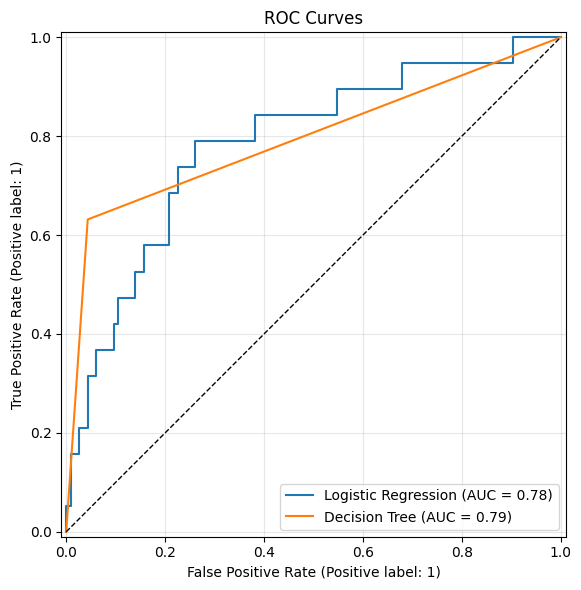

In [44]:
plt.figure(figsize=(7, 6))
ax = plt.gca()
try:
    RocCurveDisplay.from_estimator(log_reg, X_test, y_test, name="Logistic Regression", ax=ax)
    RocCurveDisplay.from_estimator(dtree, X_test, y_test, name="Decision Tree", ax=ax)
    ax.plot([0, 1], [0, 1], "k--", linewidth=1)
    plt.title("ROC Curves")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("ROC plot skipped:", e)


In [45]:
# ROC AUC else accuracy
if metrics_table["ROC AUC (Test)"].notna().any():
    best_col = "ROC AUC (Test)"
else:
    best_col = "Accuracy (Test)"

best_idx = metrics_table[best_col].values.argmax()
best_name = metrics_table.iloc[best_idx]["Model"]
best_model = {"Logistic Regression": log_reg, "Decision Tree": dtree}[best_name]

print("Best model:", best_name, "| criterion:", best_col)

Path("models").mkdir(parents=True, exist_ok=True)
model_path = Path("models") / f"best_model_{best_name.replace(' ', '_').lower()}.joblib"
joblib.dump(best_model, model_path)
print("Saved to:", model_path)


Best model: Decision Tree | criterion: ROC AUC (Test)
Saved to: models/best_model_decision_tree.joblib


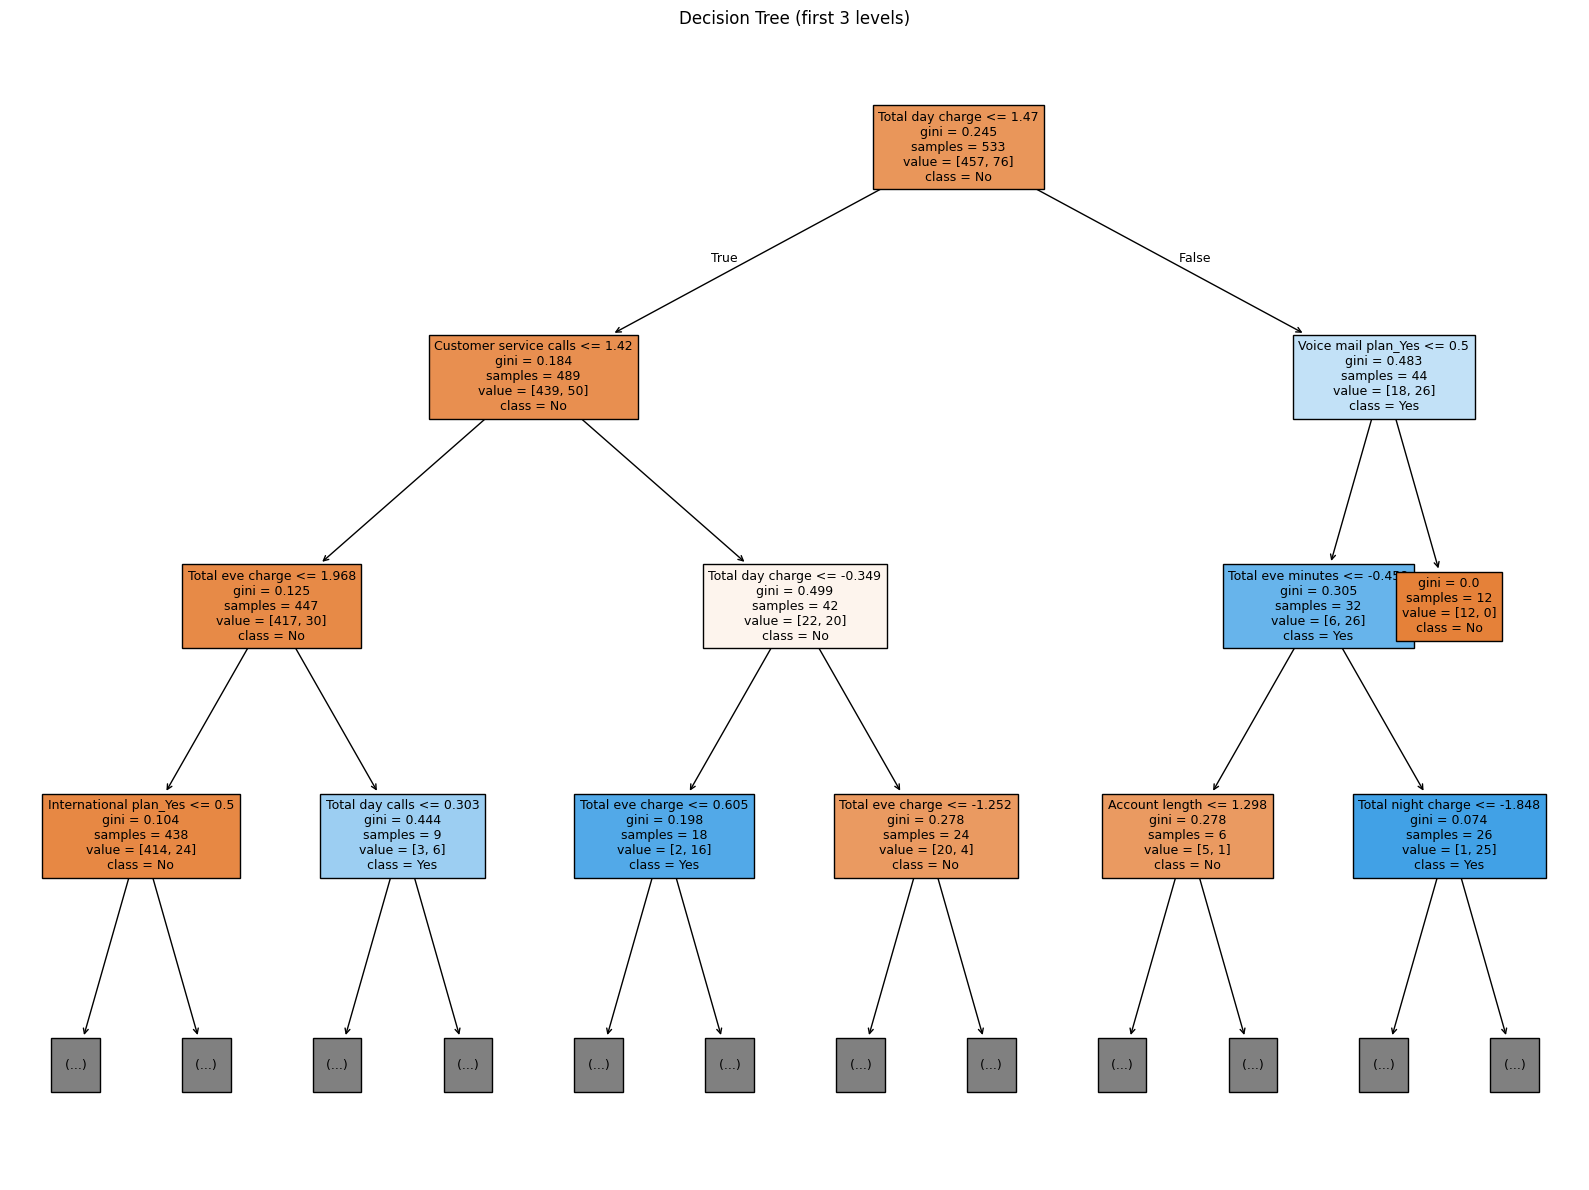

In [46]:
if "Decision Tree" == best_name:
    # Extract preprocess and feature 
    fitted_pre = best_model.named_steps["preprocess"]
    # Extract OHE object safely
    try:
        ohe = fitted_pre.named_transformers_["cat"]
    except Exception:
        ohe = None

    if ohe is not None and len(cat_cols) > 0:
        try:
            cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
        except Exception:
            cat_feature_names = ohe.get_feature_names(cat_cols)
            if not isinstance(cat_feature_names, list):
                cat_feature_names = list(cat_feature_names)
    else:
        cat_feature_names = []

    feature_names = num_cols + cat_feature_names
    clf = best_model.named_steps["model"]

    plt.figure(figsize=(16, 12))
    plot_tree(
        clf,
        feature_names=feature_names if len(feature_names) else None,
        class_names=["No", "Yes"],
        filled=True,
        max_depth=3,
        fontsize=9
    )
    plt.title("Decision Tree (first 3 levels)")
    plt.tight_layout()
    plt.show()


In [47]:
threshold_rows = []
if "log_reg" in globals():
    
    check_is_fitted(log_reg)
    probas = log_reg.predict_proba(X_test)[:, 1]
    thresholds = np.linspace(0.1, 0.9, 9)

    for t in thresholds:
        y_pred = (probas >= t).astype(int)
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, probas) if y_test.nunique() > 1 else np.nan
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        threshold_rows.append({"threshold": float(t), "accuracy": float(acc), "roc_auc": float(auc), "tpr": float(tpr), "fpr": float(fpr)})

threshold_df = pd.DataFrame(threshold_rows)
display(threshold_df)


,threshold,accuracy,roc_auc,tpr,fpr
0,0.1,0.746269,0.783982,0.736842,0.252174
1,0.2,0.798507,0.783982,0.526316,0.156522
2,0.3,0.835821,0.783982,0.368421,0.086957
3,0.4,0.865672,0.783982,0.315789,0.043478
4,0.5,0.858209,0.783982,0.157895,0.026087
5,0.6,0.873134,0.783982,0.157895,0.008696
6,0.7,0.865672,0.783982,0.052632,0.000000
7,0.8,0.865672,0.783982,0.052632,0.000000
8,0.9,0.858209,0.783982,0.000000,0.000000


In [48]:
Path("LabAssig5_stuff").mkdir(parents=True, exist_ok=True)
metrics_out = Path("LabAssig5_stuff") / "model_metrics.csv"
metrics_table.to_csv(metrics_out, index=False)
print(str(metrics_out))


LabAssig5_stuff/model_metrics.csv
